# 샤플리 값으로 설명 가능한 AI 소개

샤플리 값으로 머신러닝 모델을 설명하는 방법을 소개합니다. 샤플리 값은 바람직한 속성을 가진 협동 게임 이론에서 널리 사용되는 접근 방식입니다. 이 튜토리얼은 머신러닝 모델에 대한 샤플리 값을 계산하고 해석하는 방법에 대한 탄탄한 이해를 돕기 위해 마련되었습니다. 점점 더 복잡한 모델을 설명하기 위해 `shap` Python 패키지를 사용하여 실용적인 실습 접근 방식을 취할 것입니다. 이 문서는 살아있는 문서이며, `shap` Python 패키지에 대한 소개 역할을 합니다. 피드백이나 기여가 있으시면 이 튜토리얼을 개선하기 위해 이슈나 풀 리퀘스트를 열어주세요!

<!--
자세한 내용을 다룬 연구 논문이 많이 있습니다. 

저는 `shap`을 개발하는 과정에서 여러 가지 문제를 겪었기 때문에 그 과정에서 발생할 수 있는 한계와 잠재적 함정에 대해서도 강조할 것입니다.

그러나 이론적으로 근거가 있고 계산적으로 효율적인 것만으로는 충분하지 않으며, 좋은 설명 방법도 이해해야 합니다..-->

**Outline**

- [선형 회귀 모델 설명하기](#linear_regression)
- [일반화된 가산 회귀 모델 설명하기](#additive_regression)
- [부스트되지 않은 트리 모델 설명하기](#boosted_tree)
- [선형 로지스틱 회귀 모델 설명하기](#logistic_regression)
- [비부가치 부스트 트리 로지스틱 회귀 모델 설명하기](#non_additive_logistic)
- [상호 연관된 입력 기능 다루기](#correlated_features)
- [트랜스포머 NLP 모델 설명하기](#nlp_model)

<a id="linear_regression"></a>

## 선형 회귀 모델 설명하기

복잡한 모델을 설명하기 위해 샤플리 값을 사용하기 전에 간단한 모델에서 샤플리 값이 어떻게 작동하는지 이해하는 것이 도움이 됩니다. 가장 간단한 모델 유형 중 하나는 표준 선형 회귀이므로 아래에서는 [캘리포니아 주택 데이터 집합](https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html)에 대한 선형 회귀 모델을 훈련합니다. 이 데이터 세트는 1990년 캘리포니아 전역의 20,640개 주택 블록으로 구성되어 있으며, 목표는 8개의 서로 다른 특징으로부터 중간 주택 가격의 자연 로그를 예측하는 것입니다:

1. MedInc - 블록 그룹 내 중간 소득
2. HouseAge - 블록 그룹 내 주택 연령 중앙값
3. AveRooms - 가구당 평균 객실 수
4. AveBedrms - 가구당 평균 침실 수
5. Population - 블록 그룹 인구
6. AveOccup - 평균 가구원 수
7. Latitude - 블록 그룹 위도
8. Longitude - 블록 그룹 경도

In [1]:
import pandas as pd
import shap
import sklearn

# 대표적인 주택 가격 데이터 세트
X,y = shap.datasets.california(n_points=1000)

X100 = shap.utils.sample(X, 100) # 100 instances for use as the background distribution

#  간단한 선형 모델
model = sklearn.linear_model.LinearRegression()
model.fit(X, y)

LinearRegression()

### 모델 계수 검토

선형 모델을 이해하는 가장 일반적인 방법은 각 특징에 대해 학습된 계수를 살펴보는 것입니다. 이러한 계수는 각 입력 특징을 변경할 때 모델 출력이 얼마나 변화하는지 알려줍니다:

In [2]:
print("Model coefficients:\n")
for i in range(X.shape[1]):
    print(X.columns[i], "=", model.coef_[i].round(5))

Model coefficients:

MedInc = 0.45769
HouseAge = 0.01153
AveRooms = -0.12529
AveBedrms = 1.04053
Population = 5e-05
AveOccup = -0.29795
Latitude = -0.41204
Longitude = -0.40125


계수는 입력 특징의 값을 변경할 때 어떤 일이 일어날지 알려주는 데 유용하지만, 그 자체만으로는 특징의 전반적인 중요성을 측정하는 좋은 방법은 아닙니다. 각 계수의 값은 입력된 특징의 척도에 따라 달라지기 때문입니다. 예를 들어 집의 나이를 연도가 아닌 분 단위로 측정한다면 HouseAge 특징의 계수는 0.0115 / (365∗24∗60) = 2.18e-8이 될 것입니다. 분명히 집이 지어진 연수는 분 수보다 더 중요하지 않지만 계수 값은 훨씬 더 큽니다. 즉, 계수의 크기가 선형 모델에서 특징의 중요성을 나타내는 좋은 척도가 될 수는 없습니다.  

### 부분 종속성 플롯을 사용하여 더 완벽한 그림 그리기

모델에서 특징의 중요성을 이해하려면 해당 특징을 변경하는 것이 모델의 출력에 어떤 영향을 미치는지, 그리고 해당 특징 값의 분포를 모두 이해해야 합니다. 선형 모델에서 이를 시각화하기 위해 고전적인 부분 의존성 플롯을 작성하고 특징 값의 분포를 X축에 히스토그램으로 표시할 수 있습니다:

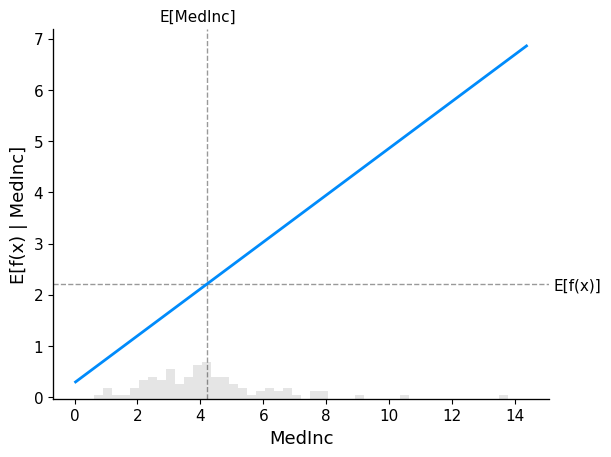

In [3]:
shap.partial_dependence_plot(
    "MedInc", model.predict, X100, ice=False,
    model_expected_value=True, feature_expected_value=True
)

위 플롯의 회색 가로선은 캘리포니아 주택 데이터 집합에 적용했을 때 모델의 예상 값을 나타냅니다. 세로 회색 선은 중위 소득 기능의 평균값을 나타냅니다. 파란색 부분 종속성 플롯 라인(중위 소득 특징을 주어진 값으로 고정했을 때 모델 출력의 평균값)은 항상 두 회색 예상 값 라인의 교점을 통과합니다. 이 교차점을 데이터 분포에 대한 부분 의존도 플롯의 '중심'으로 간주할 수 있습니다. 이 중심화의 영향은 다음에 샤플리 값으로 전환하면 명확해질 것입니다.

### 부분 종속성 플롯에서 SHAP 값 읽기

기계 학습 모델에 대한 샤플리 가치 기반 설명의 핵심 아이디어는 협력 게임 이론의 공정한 할당 결과를 사용하여 모델의 입력 기능 중 모델의 출력 $f(x)$에 대한 크레딧을 할당하는 것입니다<!--[인용]-->. 게임 이론을 머신러닝 모델과 연결하려면 모델의 입력 기능을 게임의 플레이어와 일치시키고 모델 기능을 게임의 규칙과 일치시켜야 합니다. 게임 이론에서 플레이어는 게임에 참여하거나 참여하지 않을 수 있으므로, 기능이 모델에 "참여"하거나 "참여하지 않을" 수 있는 방법이 필요합니다. 피처가 모델에 "조인"하는 것을 정의하는 가장 일반적인 방법은 해당 피처의 값을 알면 피처가 모델에 "조인"하고, 해당 특징의 값을 모르면 특징이 모델에 "조인"하지 않는다고 말하는 것입니다. 특징의 하위 집합 $S$만이 모델에 속해 있을 때 기존 모델 $f$를 평가하려면 조건부 기대값 공식을 사용하여 다른 특징들을 통합합니다. 이 공식은 두 가지 형태를 취할 수 있습니다:

$$
E[f(X) \mid X_S = x_S]
$$

<center>or</center> 

$$
E[f(X) \mid do(X_S = x_S)]
$$

첫 번째 형태에서 우리는 S의 특징값을 '관찰'하기 때문에 그 값을 알고 있습니다. 두 번째 형태에서는 S의 특징값을 '설정'하기 때문에 그 값을 알 수 있습니다. 일반적으로 두 번째 형태가 더 선호되는데, 이는 우리가 개입하여 입력을 변경할 경우 모델이 어떻게 작동할지 알려줄 뿐만 아니라 계산하기가 훨씬 쉽기 때문입니다.  <!--이 두 가지 공식의 차이점에 대한 자세한 내용은 [인과적 기능과 관찰 기능의 중요성]에 대한 자세한 글을 참조하세요.]() [TODO].--> 이 튜토리얼에서는 전적으로 두 번째 공식에 초점을 맞출 것입니다. 또한 머신 러닝 모델의 조건부 기대 함수에 적용된 샤플리 값을 지칭하기 위해 보다 구체적인 용어인 SHAP 값을 사용할 것입니다.

SHAP 값은 계산하기가 매우 복잡할 수 있지만(일반적으로 NP가 어렵습니다), 선형 모델은 매우 간단하여 부분 의존도 플롯에서 바로 SHAP 값을 읽을 수 있습니다. 예측 $f(x)$를 설명할 때 특정 특징 $i$에 대한 SHAP 값은 특징의 값 $x_i$에 대한 예상 모델 출력과 부분 의존성 플롯의 차이일 뿐입니다:

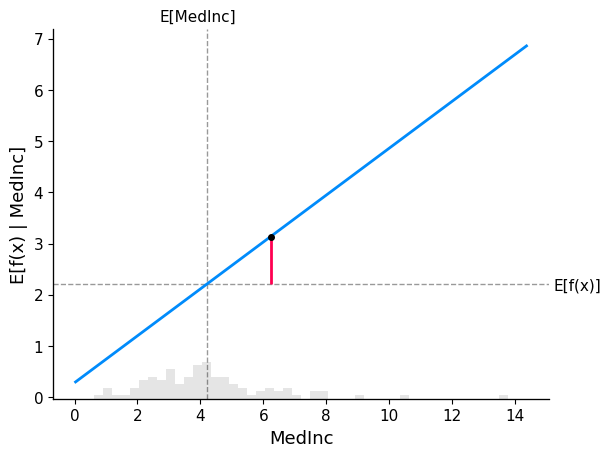

In [4]:
# 선형 모델의 SHAP 값을 계산합니다.
explainer = shap.Explainer(model.predict, X100)
shap_values = explainer(X)

# 표준 부분 종속성 플롯 만들기
sample_ind = 20
shap.partial_dependence_plot(
    "MedInc", model.predict, X100, model_expected_value=True,
    feature_expected_value=True, ice=False,
    shap_values=shap_values[sample_ind:sample_ind+1,:]
)

고전적인 부분 종속성 플롯과 SHAP 값 사이의 밀접한 대응은 전체 데이터 집합에서 특정 특징에 대한 SHAP 값을 플롯하면 해당 특징에 대한 부분 종속성 플롯의 평균 중심 버전을 정확하게 추적할 수 있다는 것을 의미합니다:

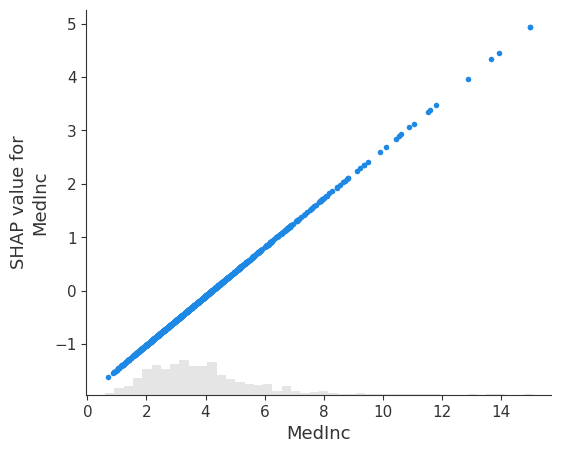

In [5]:
shap.plots.scatter(shap_values[:,"MedInc"])

### 샤플리 값의 가산적 특성

샤플리 값의 기본 속성 중 하나는 모든 플레이어가 존재할 때의 게임 결과와 플레이어가 존재하지 않을 때의 게임 결과의 차이를 항상 합산한다는 것입니다. 머신 러닝 모델의 경우, 이는 모든 입력 특징의 SHAP 값이 항상 설명하려는 예측에 대한 기준(예상) 모델 출력과 현재 모델 출력의 차이로 합산된다는 것을 의미합니다. 이를 가장 쉽게 확인할 수 있는 방법은 주택 가격 $E[f(X)]$에 대한 배경 사전 기대치에서 시작하여 현재 모델 출력 $f(x)$에 도달할 때까지 한 번에 하나씩 특징을 추가하는 폭포수 플롯을 통해 확인할 수 있습니다:

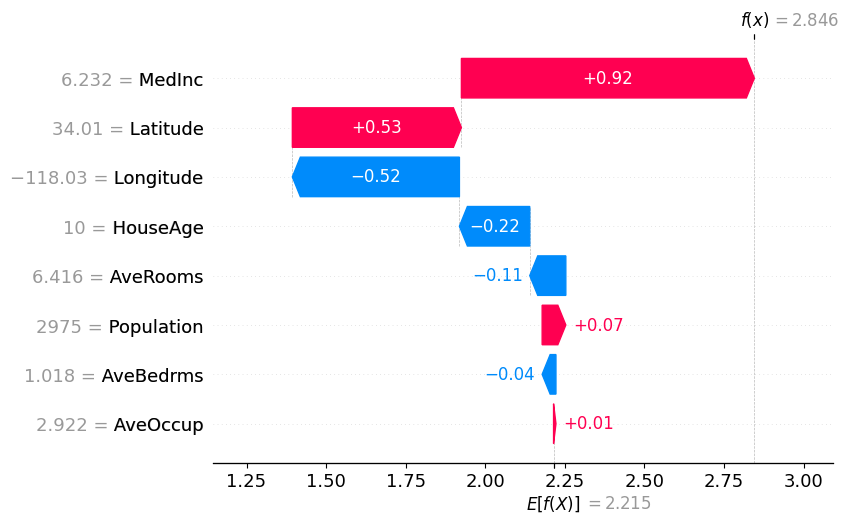

In [6]:
# waterfall_plot은 shap_values.base_values에서 model.predict(X)[sample_ind]로 변환하는 방법을 보여줍니다.
shap.plots.waterfall(shap_values[sample_ind], max_display=14)

## 가산 회귀 모델 설명하기

<a id="additive_regression"></a>

선형 모델의 부분 종속성 플롯이 SHAP 값과 밀접하게 연결되어 있는 이유는 모델의 각 특징이 다른 모든 특징과 독립적으로 처리되기 때문입니다(효과는 단지 합산되기만 합니다). 직선의 선형 요구 사항을 완화하면서 이러한 가산적 특성을 유지할 수 있습니다. 그 결과 잘 알려진 일반화 가산 모델(GAM)이 탄생했습니다. 이러한 유형의 모델을 훈련하는 방법에는 여러 가지가 있지만(예: XGBoost 모델을 깊이 1로 설정), 여기서는 이를 위해 특별히 설계된 InterpretML의 설명 가능한 부스팅 머신을 사용하겠습니다.

In [8]:
pip install interpret

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 8.3 MB/s eta 0:00:0000:0100:010m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 758.0/758.0 kB 52.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 22.9 MB/s eta 0:00:0000:0100:01
  Using cached requests-2.28.2-py3-none-any.whl (62 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 25.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 23.9 MB/s eta 0:00:0000:010:01m
  Using cached dill-0.3.6-py3-none-any.whl (110 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 13.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.8/101.8 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 246.1/246.1 kB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.2/13.2 MB 20.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 kB 10.3 MB/s eta 0:00

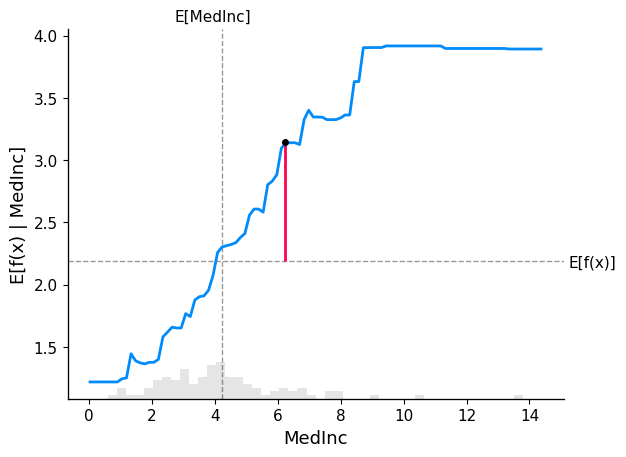

In [7]:
# 데이터에 GAM 모델 맞추기
import interpret.glassbox
model_ebm = interpret.glassbox.ExplainableBoostingRegressor(interactions=0)
model_ebm.fit(X, y)

# SHAP으로 GAM 모델 설명
explainer_ebm = shap.Explainer(model_ebm.predict, X100)
shap_values_ebm = explainer_ebm(X)

# 단일 SHAP 값이 겹쳐진 표준 부분 종속성 플롯을 만듭니다.
fig,ax = shap.partial_dependence_plot(
    "MedInc", model_ebm.predict, X100, model_expected_value=True,
    feature_expected_value=True, show=False, ice=False,
    shap_values=shap_values_ebm[sample_ind:sample_ind+1,:]
)

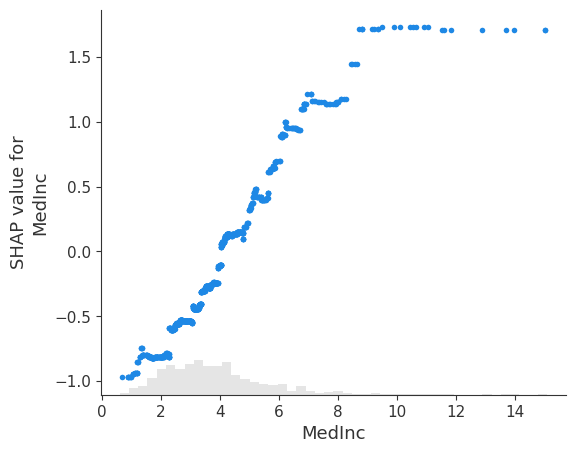

In [9]:
shap.plots.scatter(shap_values_ebm[:,"MedInc"])

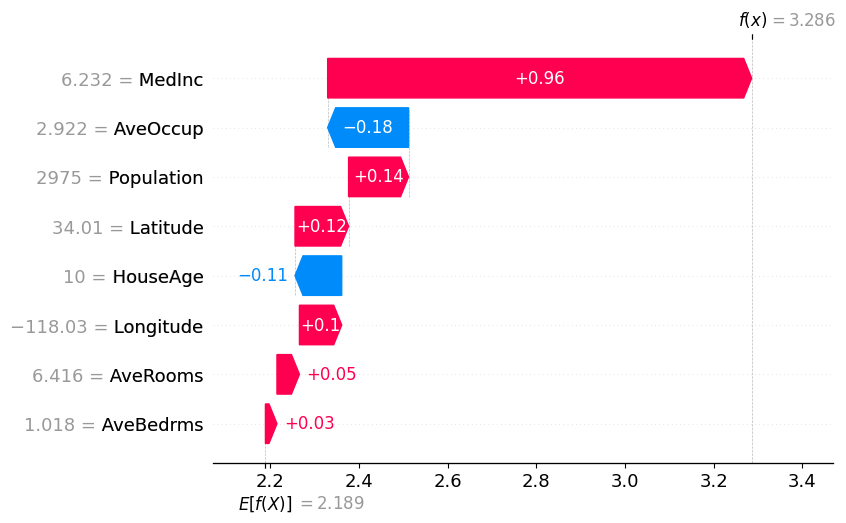

In [10]:
# waterfall_plot은 explainer.expected_value에서 model.predict(X)[sample_ind]로 변환하는 방법을 보여줍니다.
shap.plots.waterfall(shap_values_ebm[sample_ind])

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


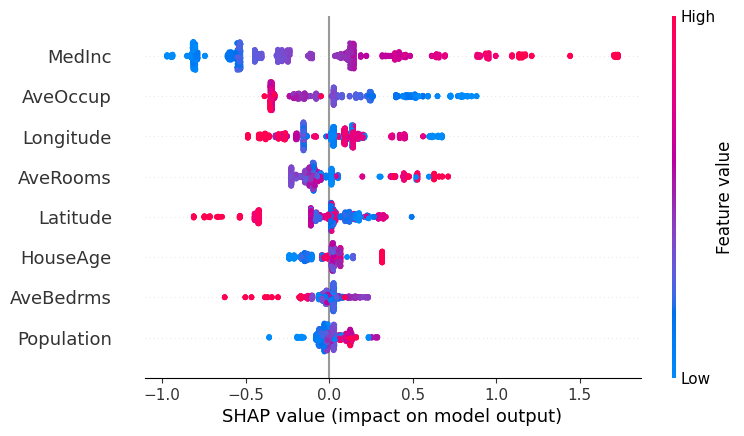

In [11]:
# waterfall_plot은 explainer.expected_value에서 model.predict(X)[sample_ind]로 변환하는 방법을 보여줍니다.
shap.plots.beeswarm(shap_values_ebm)

<a id="boosted_tree"></a>
## 부스트되지 않은 트리 모델 설명하기

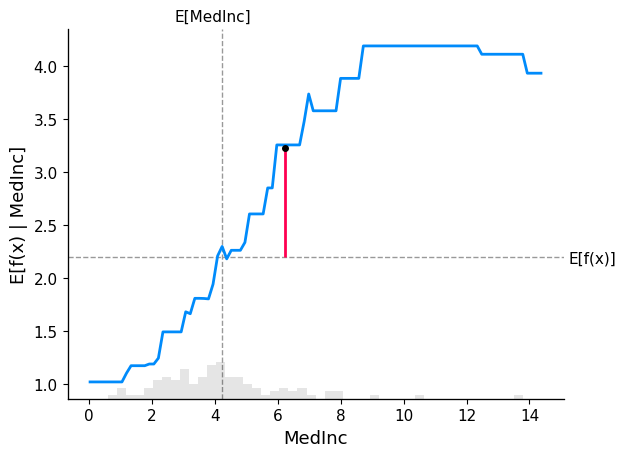

In [12]:
#  XGBoost 모델 학습
import xgboost
model_xgb = xgboost.XGBRegressor(n_estimators=100, max_depth=2).fit(X, y)

# SHAP으로 GAM 모델 설명
explainer_xgb = shap.Explainer(model_xgb, X100)
shap_values_xgb = explainer_xgb(X)

# 단일 SHAP 값이 겹쳐진 표준 부분 종속성 플롯을 만듭니다.
fig,ax = shap.partial_dependence_plot(
    "MedInc", model_xgb.predict, X100, model_expected_value=True,
    feature_expected_value=True, show=False, ice=False,
    shap_values=shap_values_xgb[sample_ind:sample_ind+1,:]
)

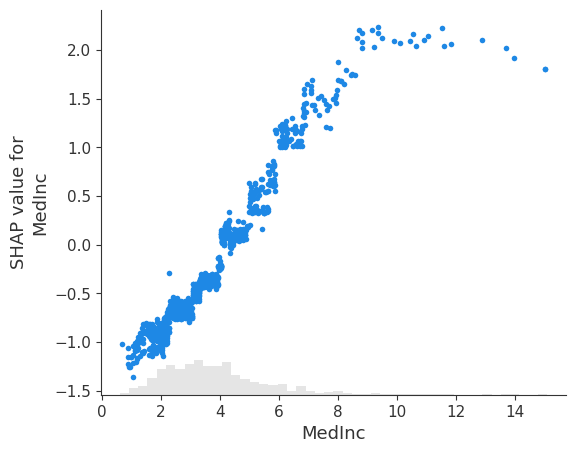

In [13]:
shap.plots.scatter(shap_values_xgb[:,"MedInc"])

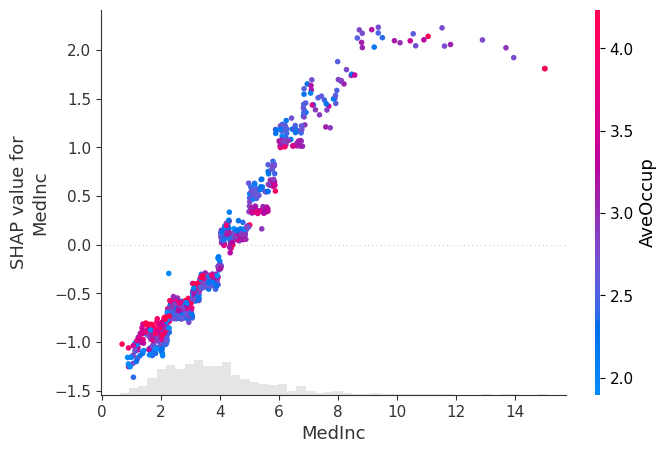

In [14]:
shap.plots.scatter(shap_values_xgb[:,"MedInc"], color=shap_values)

<a id="logistic_regression"></a>
## 선형 로지스틱 회귀 모델 설명하기

In [15]:
# 고전적인 성인 인구조사 데이터 세트 가격 데이터 세트
X_adult,y_adult = shap.datasets.adult()

# 간단한 선형 물류 모델
model_adult = sklearn.linear_model.LogisticRegression(max_iter=10000)
model_adult.fit(X_adult, y_adult)

def model_adult_proba(x):
    return model_adult.predict_proba(x)[:,1]
def model_adult_log_odds(x):
    p = model_adult.predict_log_proba(x)
    return p[:,1] - p[:,0]

선형 로지스틱 회귀 모델의 확률을 설명하는 것은 입력이 선형적이지 않다는 점에 유의하세요.

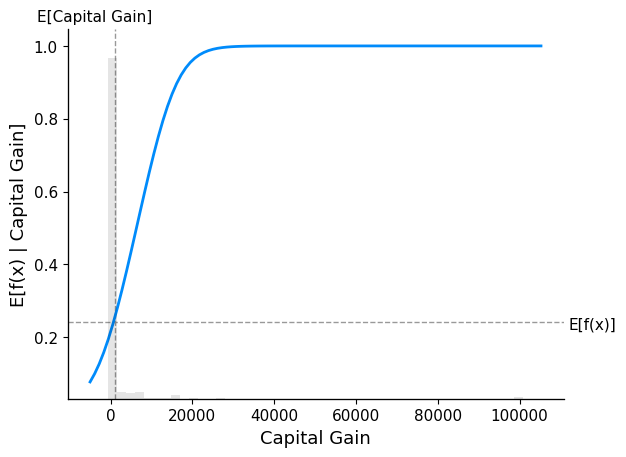

In [16]:
# 표준 부분 종속성 플롯 만들기
sample_ind = 18
fig,ax = shap.partial_dependence_plot(
    "Capital Gain", model_adult_proba, X_adult, model_expected_value=True,
    feature_expected_value=True, show=False, ice=False
)


선형 로지스틱 회귀 모델의 확률을 설명하기 위해 SHAP을 사용하면 강력한 상호 작용 효과를 볼 수 있습니다. 이는 선형 로지스틱 회귀 모델이 확률 공간에서 덧셈이 아니기 때문입니다.

In [17]:
# 선형 모델의 SHAP 값을 계산합니다.
background_adult = shap.maskers.Independent(X_adult, max_samples=100)
explainer = shap.Explainer(model_adult_proba, background_adult)
shap_values_adult = explainer(X_adult[:1000])

Permutation explainer: 1001it [00:27, 23.99it/s]             


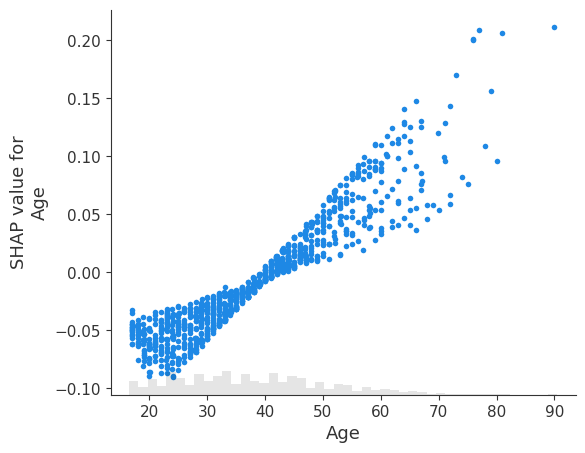

In [18]:
shap.plots.scatter(shap_values_adult[:,"Age"])

대신 모델의 로그-합계 출력을 설명하면 모델 입력과 모델 출력 간의 완벽한 선형 관계를 볼 수 있습니다. 설명하는 모델의 단위가 무엇인지 기억하는 것이 중요하며, 다른 모델 출력을 설명하면 모델의 동작에 대해 매우 다른 관점을 갖게 될 수 있습니다.

In [19]:
# 선형 모델의 SHAP 값을 계산합니다.
explainer_log_odds = shap.Explainer(model_adult_log_odds, background_adult)
shap_values_adult_log_odds = explainer_log_odds(X_adult[:1000])

Permutation explainer: 1001it [00:27, 23.21it/s]              


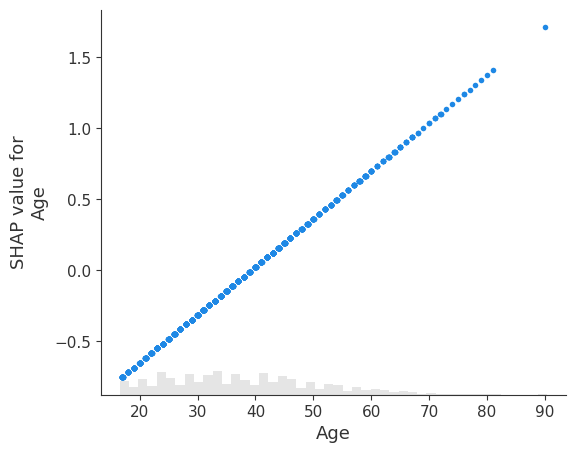

In [20]:
shap.plots.scatter(shap_values_adult_log_odds[:,"Age"])

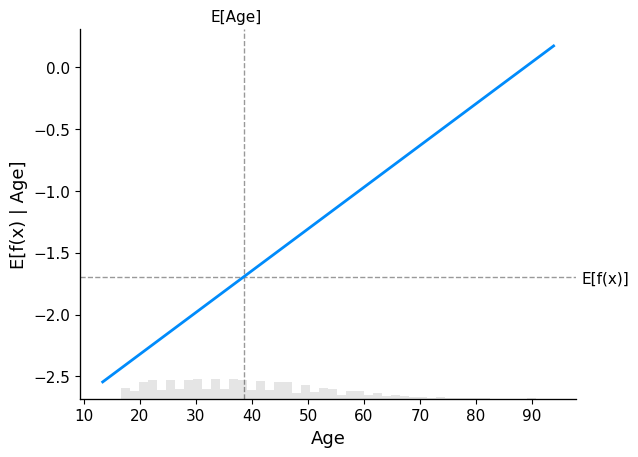

In [21]:
# 표준 부분 종속성 플롯 만들기
sample_ind = 18
fig,ax = shap.partial_dependence_plot(
    "Age", model_adult_log_odds, X_adult, model_expected_value=True,
    feature_expected_value=True, show=False, ice=False
)


<a id="non_additive_logistic"></a>
## 비부가치 부스트 트리 로지스틱 회귀 모델 설명하기

In [22]:
# XGBoost 모델 학습
model = xgboost.XGBClassifier(n_estimators=100, max_depth=2).fit(X_adult, y_adult*1, eval_metric="logloss")

# SHAP 값 계산
explainer = shap.Explainer(model, background_adult)
shap_values = explainer(X_adult)

# 플로팅에 사용할 데이터의 표시 버전을 설정합니다(문자열 값 포함).
shap_values.display_data = shap.datasets.adult(display=True)[0].values

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
 94%|=================== | 30678/32561 [00:13<00:00]       

기본적으로 SHAP 막대형 막대 그래프는 데이터 집합의 모든 인스턴스(행)에 대한 각 특징의 평균 절대값을 취합니다.

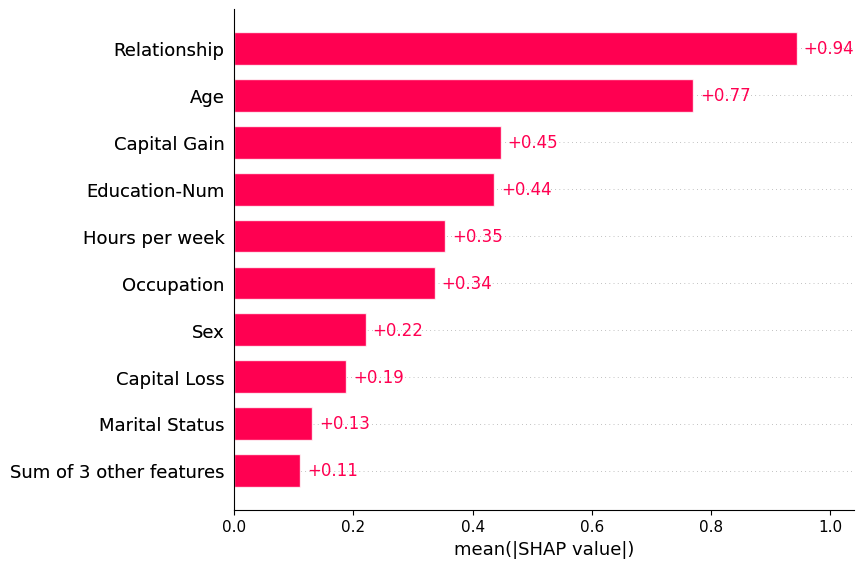

In [23]:
shap.plots.bar(shap_values)

그러나 평균 절대값만이 특징 중요도의 전역 측정값을 만드는 유일한 방법은 아니며, 여러 가지 변환을 사용할 수 있습니다. 여기에서는 최대 절대값을 사용하면 영향이 미미하지만 크기가 큰 자본 이득 및 자본 손실 특징을 높이는 방법을 보여줍니다.

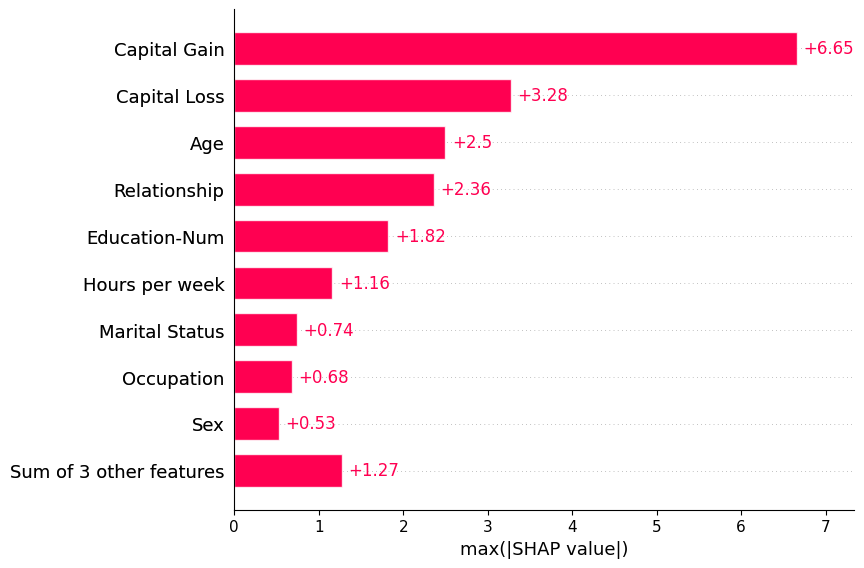

In [24]:
shap.plots.bar(shap_values.abs.max(0))

조금 더 복잡하게 처리하고 싶다면 벌집형 플롯을 사용하여 각 특징에 대한 SHAP 값의 전체 분포를 요약할 수 있습니다.

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


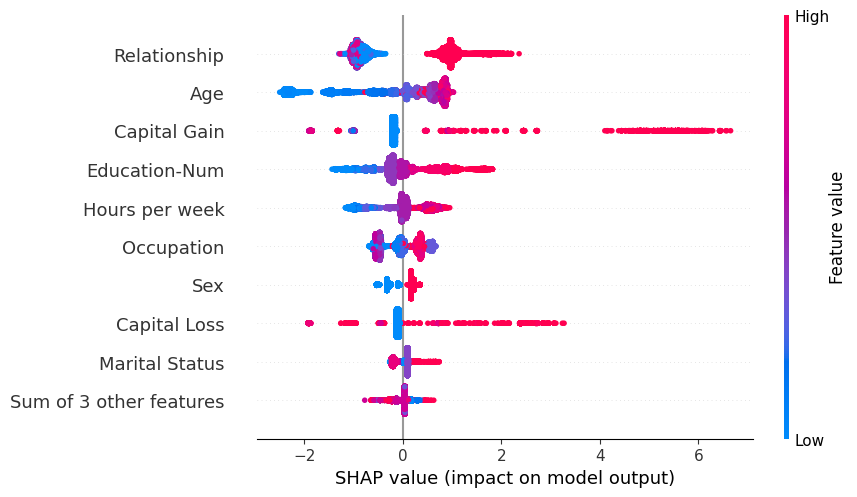

In [25]:
shap.plots.beeswarm(shap_values)

절대값을 취하고 단색을 사용하면 막대형 플롯의 복잡성과 전체 벌집형 플롯의 복잡성 사이에서 절충점을 찾을 수 있습니다. 위의 막대형 플롯은 아래 벌집형 플롯에 표시된 값의 요약 통계일 뿐이라는 점에 유의하세요.

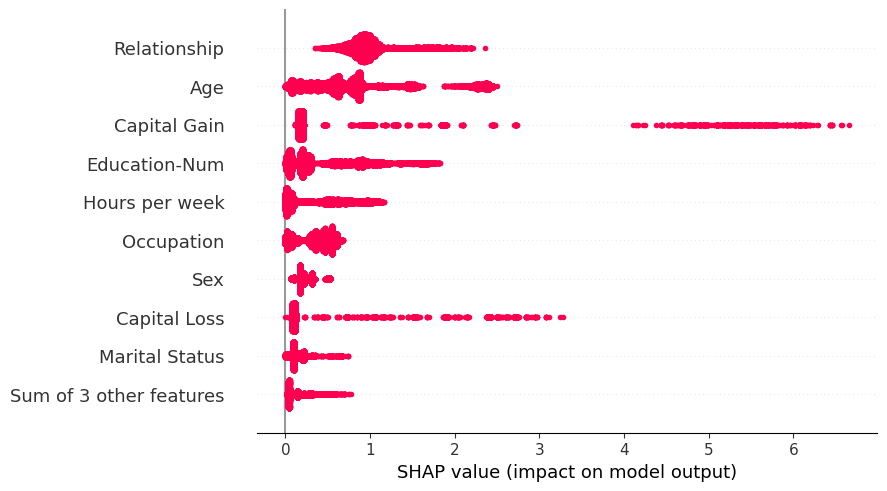

In [26]:
shap.plots.beeswarm(shap_values.abs, color="shap_red")

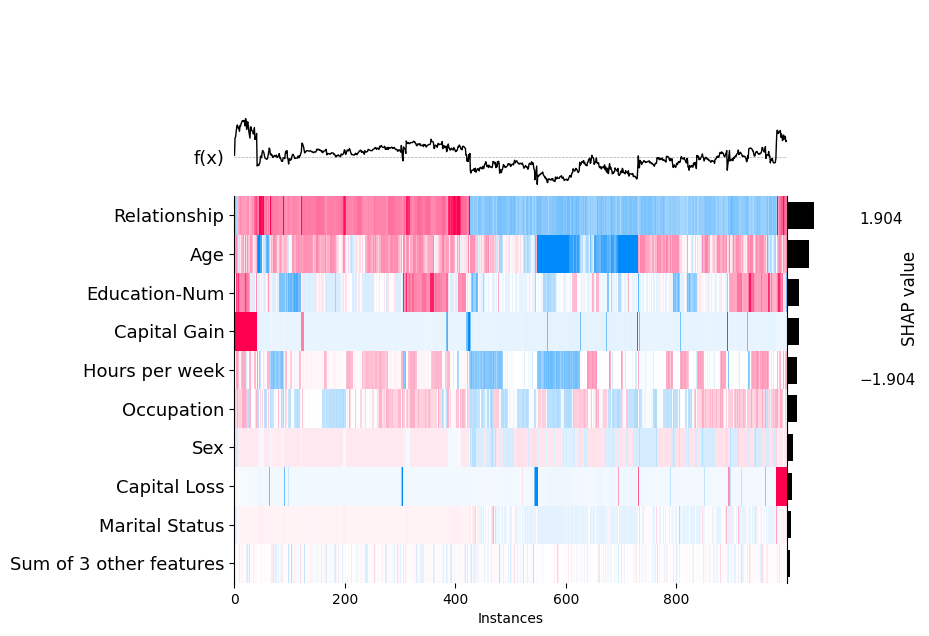

In [27]:
shap.plots.heatmap(shap_values[:1000])

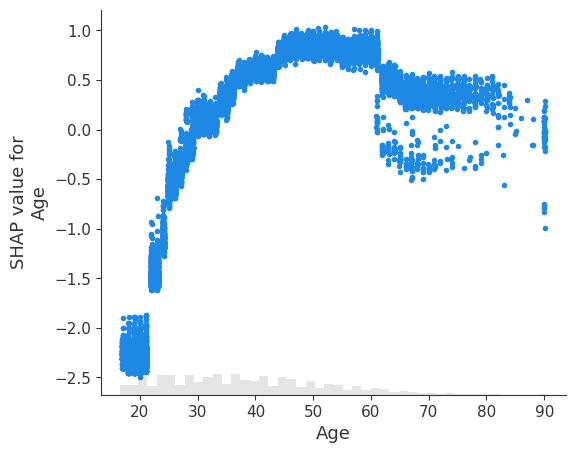

In [29]:
shap.plots.scatter(shap_values[:,"Age"])

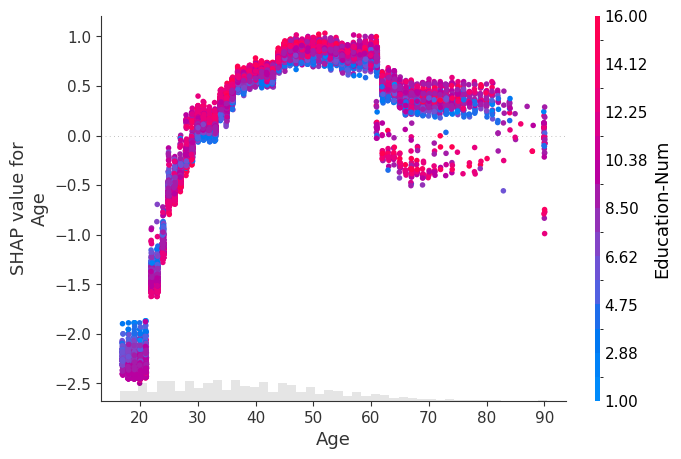

In [30]:
shap.plots.scatter(shap_values[:,"Age"], color=shap_values)

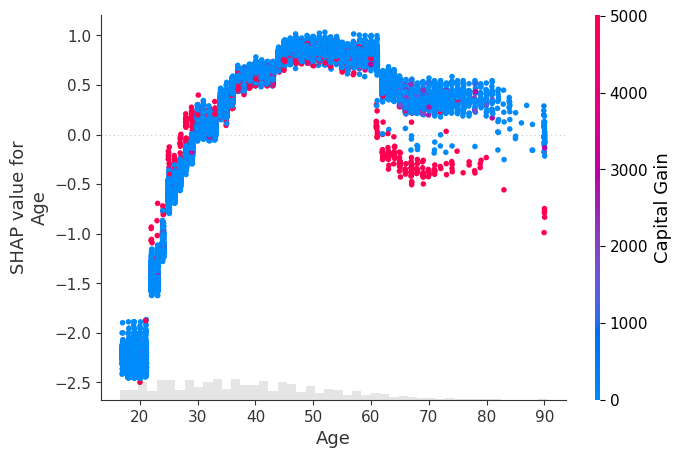

In [31]:
shap.plots.scatter(shap_values[:,"Age"], color=shap_values[:,"Capital Gain"])

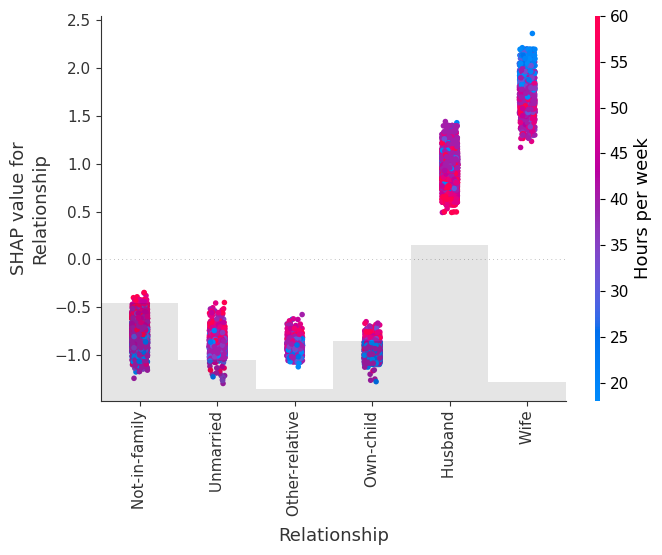

In [32]:
shap.plots.scatter(shap_values[:,"Relationship"], color=shap_values)

<a id="correlated_features"></a>
## 상호 연관된 특징 다루기

In [33]:
clustering = shap.utils.hclust(X_adult, y_adult)

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


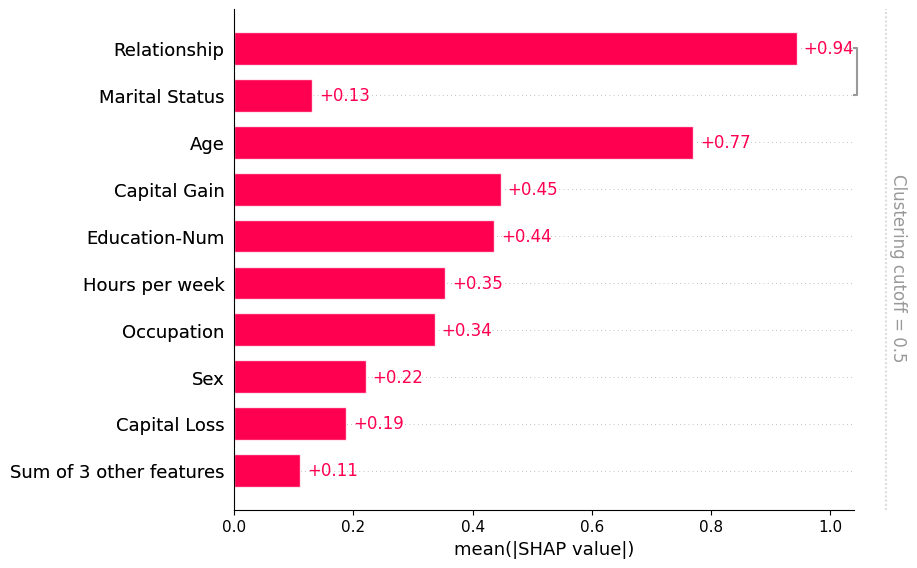

In [34]:
shap.plots.bar(shap_values, clustering=clustering)

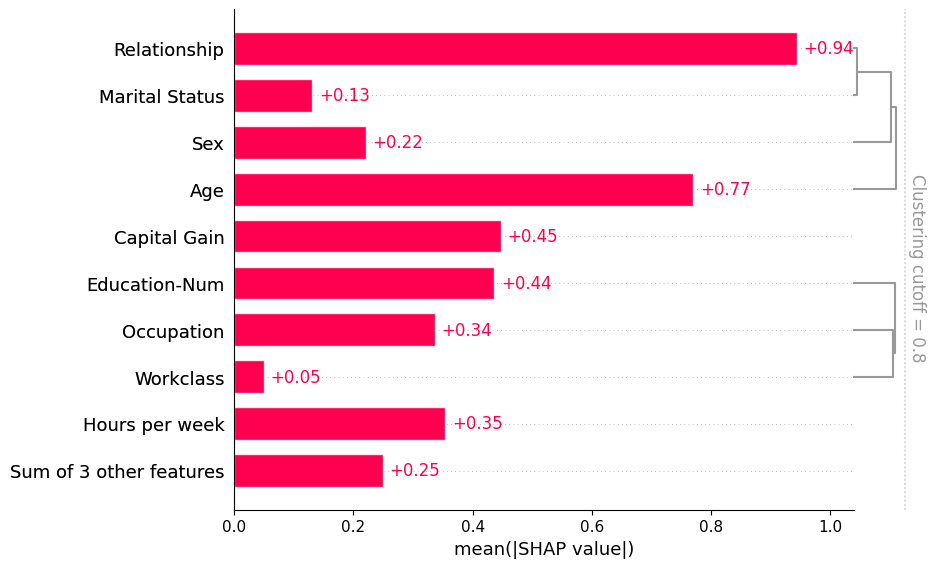

In [35]:
shap.plots.bar(shap_values, clustering=clustering, clustering_cutoff=0.8)

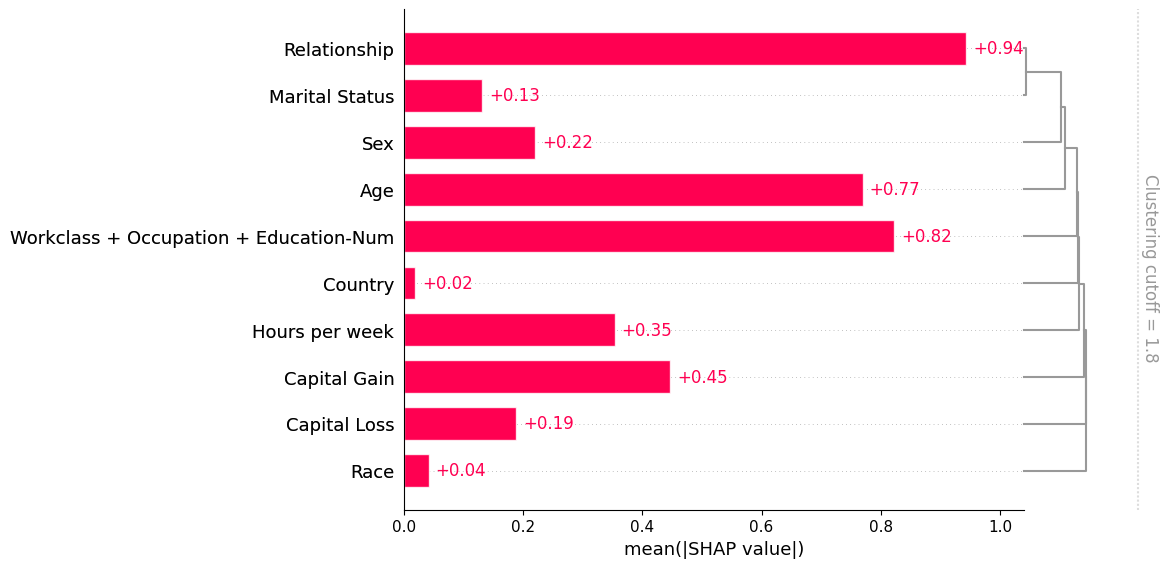

In [36]:
shap.plots.bar(shap_values, clustering=clustering, clustering_cutoff=1.8)

<a id="nlp_model"></a>
## 트랜스포머 NLP 모델 설명하기

이는 고도로 구조화된 입력이 있는 복잡한 모델 유형에 SHAP을 어떻게 적용할 수 있는지 보여줍니다.

In [8]:
import transformers
import datasets
import torch
import numpy as np
import scipy as sp
import shap

# BERT 감정 분석 모델 로드
tokenizer = transformers.DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")
model = transformers.DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased-finetuned-sst-2-english"
).cuda()

# 예측 함수 정의
def f(x):
    tv = torch.tensor([tokenizer.encode(v, padding='max_length', max_length=500, truncation=True) for v in x]).cuda()
    outputs = model(tv)[0].detach().cpu().numpy()
    scores = (np.exp(outputs).T / np.exp(outputs).sum(-1)).T
    val = sp.special.logit(scores[:,1]) # use one vs rest logit units
    return val

# 토큰 마스커를 사용하여 설명자 구축하기
explainer = shap.Explainer(f, tokenizer)

# IMDB 리뷰에 대한 모델의 예측을 설명하세요.
imdb_train = datasets.load_dataset("imdb")["train"]
shap_values = explainer(imdb_train[:10], fixed_context=1, batch_size=2)

Found cached dataset imdb (/root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0)


  0%|          | 0/3 [00:00<?, ?it/s]

Partition explainer: 9it [00:16,  1.64s/it]Token indices sequence length is longer than the specified maximum sequence length for this model (720 > 512). Running this sequence through the model will result in indexing errors
Partition explainer: 11it [00:22,  3.79s/it]


In [9]:
# 문장의 설명 플롯
shap.plots.text(shap_values[2])

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


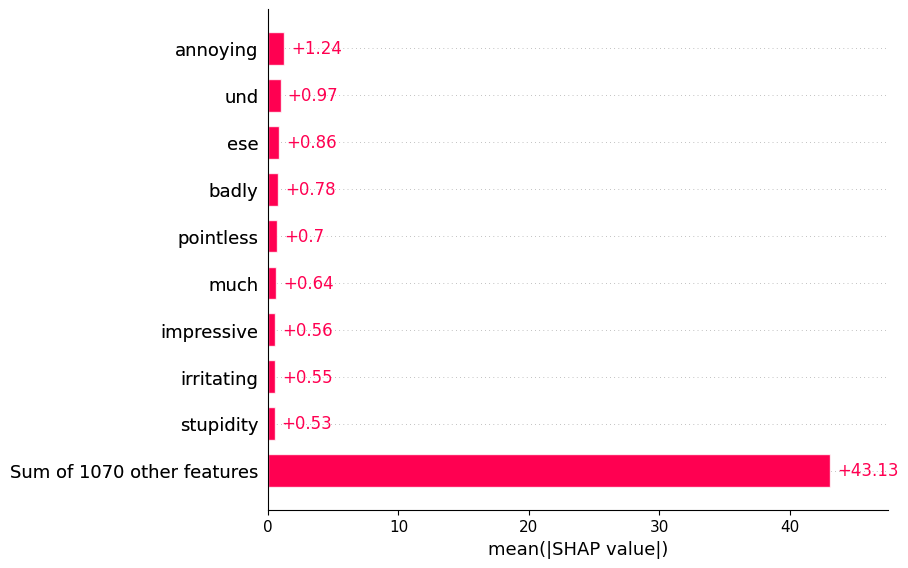

In [6]:
shap.plots.bar(shap_values.abs.mean(0))

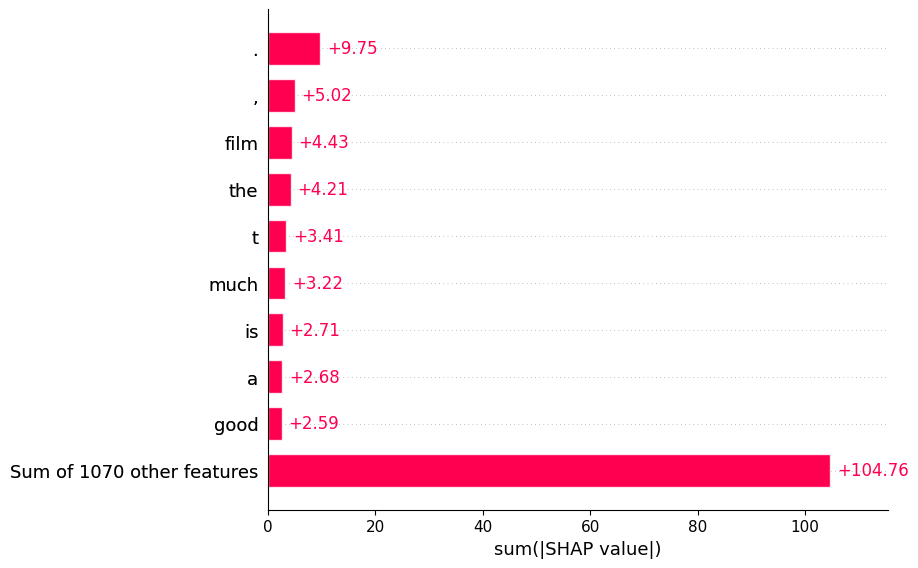

In [7]:
shap.plots.bar(shap_values.abs.sum(0))

<hr>
Have an idea for more helpful examples? Pull requests that add to this documentation notebook are encouraged! 